## References: 
https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html \
https://github.com/qiskit-community/qiskit-machine-learning/tree/main/qiskit_machine_learning \
https://github.com/Qiskit/qiskit/tree/main/qiskit

# Quantum Neural Networks (QNNs)
We provide a simple demo of quantum neural networks and how they can be executed through a real backend.

## Table of Contents

* [Prerequisites](#prereqs)
* [MNIST Dataset](#mnist)
* [Construction of QNN](#qnn)
* [Training/Testing on simulator](#sim)
* [Training/Testing on ibm_rensselaer](#rpi)

Let's start by importing all the libraries that will be needed:

<a id="prereqs"></a>
## Prerequisites
- python (3.11.0 - 3.13.0)
- matplotlib (3.9.1 - 3.9.2)
- numpy (1.26.4)
- pytorch (2.4.0 - 2.5.0)
- qiskit (1.0.2 - 1.2.4)
- qiskit-aer (0.14.2 - 0.15.1)
- qiskit-ibm-runtime (0.23.0 - 0.30.0)
- qiskit-algorithms (0.3.0)
- qiskit-machine-learning (0.7.2)

In [2]:
# Make sure python version is as specified above.
%pip install matplotlib
%pip install numpy
%pip install torch
%pip install torchvision
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install qiskit-algorithms
%pip install qiskit-machine-learning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [3]:
from torch import manual_seed
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

import math

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)

from qiskit.primitives import (
    StatevectorSampler,
    BackendSampler as BackendSampler,
    BackendSamplerV2 as BackendSamplerV2,
)

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# Set seed for random generators
algorithm_globals.random_seed = 42

<a id="mnist"></a>
# Loading MNIST dataset
Here, we download the MNIST dataset through a torchvision function. You may notice that we are downloading resized images of the original MNIST dataset (2x2 vs 28x28). We will explain why in the construction of the quantum neural network. The original images are shown below (28x28).

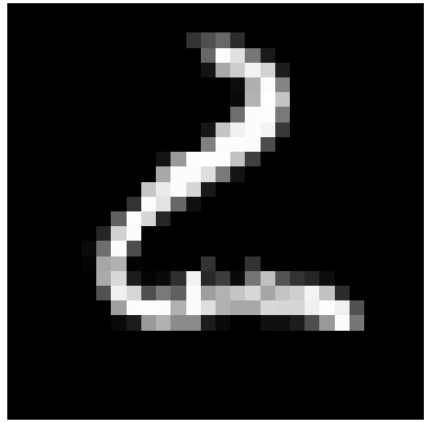 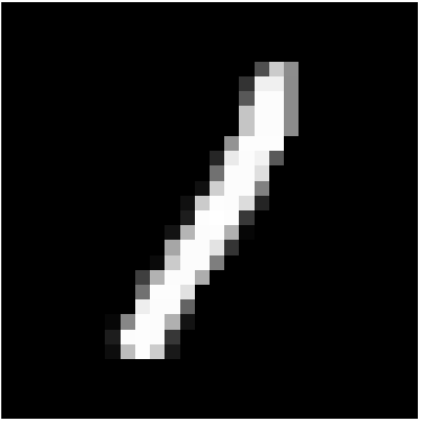

After running through this example, you can experiment with the <b>number of classes</b> being classified, <b>number of pixels</b> as input data (square root of number of qubits), and the <b>training/testing samples</b>. Note that as you increase these parameters, the execution time of the circuit will also increase.


In [4]:
# Set shuffle seed (for reproducibility)
manual_seed(42)
num_classes = 2
# Perfect square number of qubits for img dimension (Ex: 11x11 image)
num_qubits = 4
img_dim = int(math.sqrt(num_qubits))
# Samples per class
training_samples = 75
test_samples = 25

# Use pre-defined torchvision function to load MNIST train data with transforms applied at download (resizing to desired pixel length)
full_training_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                            transforms.ToTensor()])
)

train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

# Gather specified number of training samples for each class (Ex: 75 samples of digit 3, 75 samples of 4, etc.)
subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:training_samples]
    subset.extend(idx)

train.data = full_training_data.data[subset]
train.targets = full_training_data.targets[subset]

# Load in testing data
test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.Resize((img_dim, img_dim)),
                                                                             transforms.ToTensor()])
)

# Gather specified number of testing samples for each class (Ex: 25 samples of digit 3, 25 samples of 4, etc.)
subset = []
for i in range(num_classes):
    idx = np.where(full_training_data.targets == i)[0][:test_samples]
    subset.extend(idx)
    
test.data = full_training_data.data[subset]
test.targets = full_training_data.targets[subset]

print("Train subset size:", len(train))
print("Test subset size:", len(test))

# Function that takes in a dataset and prints out samples for each class to verify
# Returns flattened images (1-D vector), ground truth one hot vectors, and images themselves of each class
def count(dataset):
    counter = {}
    features = []
    labels = []
    imgs = []
    for i in range(len(dataset)):
        im, class_idx = dataset[i]
        imgs.append(im)
        features.append(np.reshape(im, -1))
        one_hot = np.eye(num_classes)[class_idx]
        labels.append(one_hot)
        if class_idx not in counter:
            counter[class_idx] = 0
        counter[class_idx] += 1
    counter = dict(sorted(counter.items(), key=lambda x: x[0]))

    for key, value in counter.items():
        print(key, ":", value)
    return np.array(features), np.array(labels), np.array(imgs)

# Shuffles each array of flattened images, ground truths, and images to randomize samples
# Prevents errors in training
print("Training Dataset")
train_feats, train_labels, train_imgs = count(train)
indices = np.arange(train_feats.shape[0])
np.random.shuffle(indices)
train_feats = train_feats[indices]
train_labels = train_labels[indices]
train_imgs = train_imgs[indices]
# Should be (num samples, total pixel count)
print(train_feats.shape)
# Should be (num samples, num classses)
print(train_labels.shape)
print("\n")

# Same for the training dataset
print("Testing Dataset")
test_feats, test_labels, test_imgs = count(test)
indices = np.arange(test_feats.shape[0])
np.random.shuffle(indices)
test_feats = test_feats[indices]
test_labels = test_labels[indices]
test_imgs = test_imgs[indices]
# Should be (num samples, total pixel count)
print(test_feats.shape)
# Should be (num samples, num classses)
print(test_labels.shape)

Train subset size: 150
Test subset size: 50
Training Dataset
0 : 75
1 : 75
(150, 4)
(150, 2)


Testing Dataset
0 : 25
1 : 25
(50, 4)
(50, 2)


The training dataset has 150 images
After the shuffle the 0th image has class index 1
(2, 2, 1)
Image shape is (2, 2, 1)


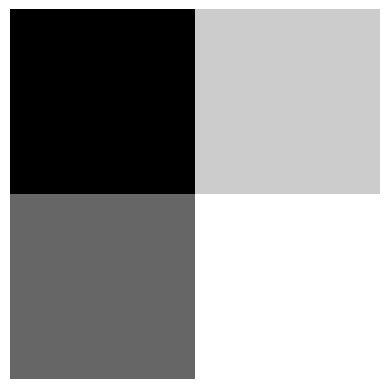

After the shuffle the 0th image has class index 0
(2, 2, 1)
Image shape is (2, 2, 1)


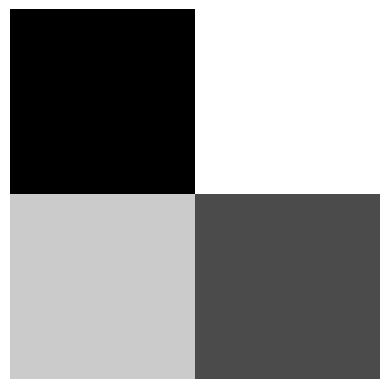

After the shuffle the 0th image has class index 0
(2, 2, 1)
Image shape is (2, 2, 1)


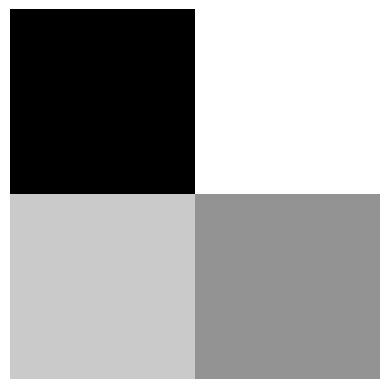

In [5]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(train)
print(f'The training dataset has {n} images')

for i in range(3):
    # Randomly shuffle the image indices
    indices = list(range(n))
    random.shuffle(indices)

    # Get the image and the class id of the 0th image after the shuffle.
    im, class_idx = train[indices[0]]
    
    print(f'After the shuffle the 0th image has class index {class_idx}')

    # Convert the image from an array back to a numpy 3d array
    im_np = im.numpy().transpose((1, 2, 0))
    print(im_np.shape)
    print(f'Image shape is {im_np.shape}')

    # Display the image
    plt.imshow(im_np, cmap='gray')
    plt.axis('off')
    plt.show()

<a id="qnn"></a>
# Construction of QNN

Quantum Neural Networks are fundamentally just parameterized quantum circuits, circuits whose gates have parameters that can be adjusted.

First, we initialize a QiskitRuntimeService to access the backend and simulator for our desired quantum computer. \
More information on the class is available in IBM documentation: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService.

In [6]:
service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer")
fake_backend = AerSimulator.from_backend(backend)
print(backend)

num_qubits = len(train_feats[0])
print(num_qubits)

<IBMBackend('ibm_rensselaer')>
4


The general structure of a quantum neural network that we will follow is outlined below:

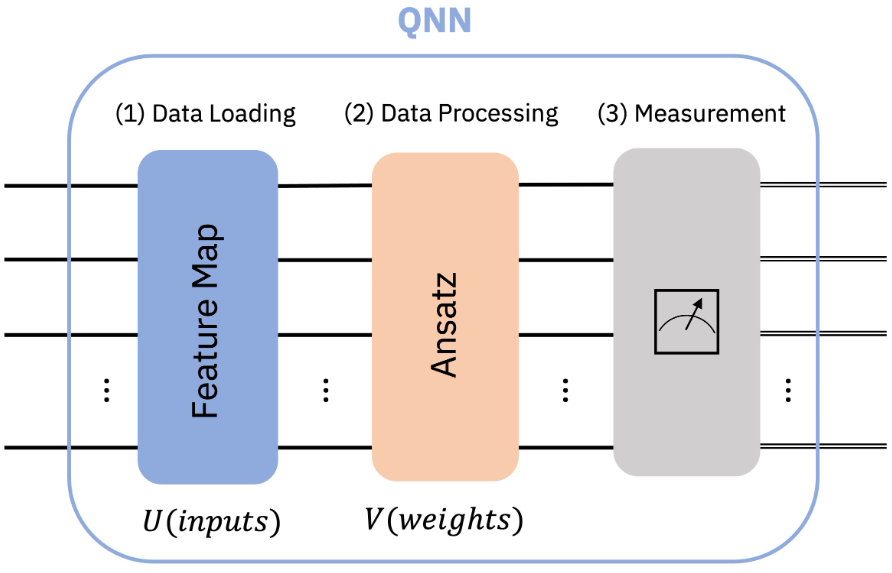

*Credit: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html*

We begin with the data loading step.

## Feature Maps
In this step, classical data is transformed into a quantum state. This process involves encoding the features of the data into qubits. The feature map determines how the data is represented in the quantum state. In this simple example, we will represent each pixel in the image as a qubit. We utilize the ZZFeatureMap function to encode the data into the quantum circuit. This method constructs a quantum circuit consisting of RZ and CNOT gates. There are other methods of encoding data such as Basis encoding, Amplitude encoding, and Angle encoding that we will not explain here. \
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap

<b>Note</b>: Our RPI Quantum System One (ibm_rensselaer) is equipped with a 127-qubit Eagle processor. Using our method of mapping each pixel into a qubit, this limits the image dimensions we must have to be 11x11 (121 pixels).

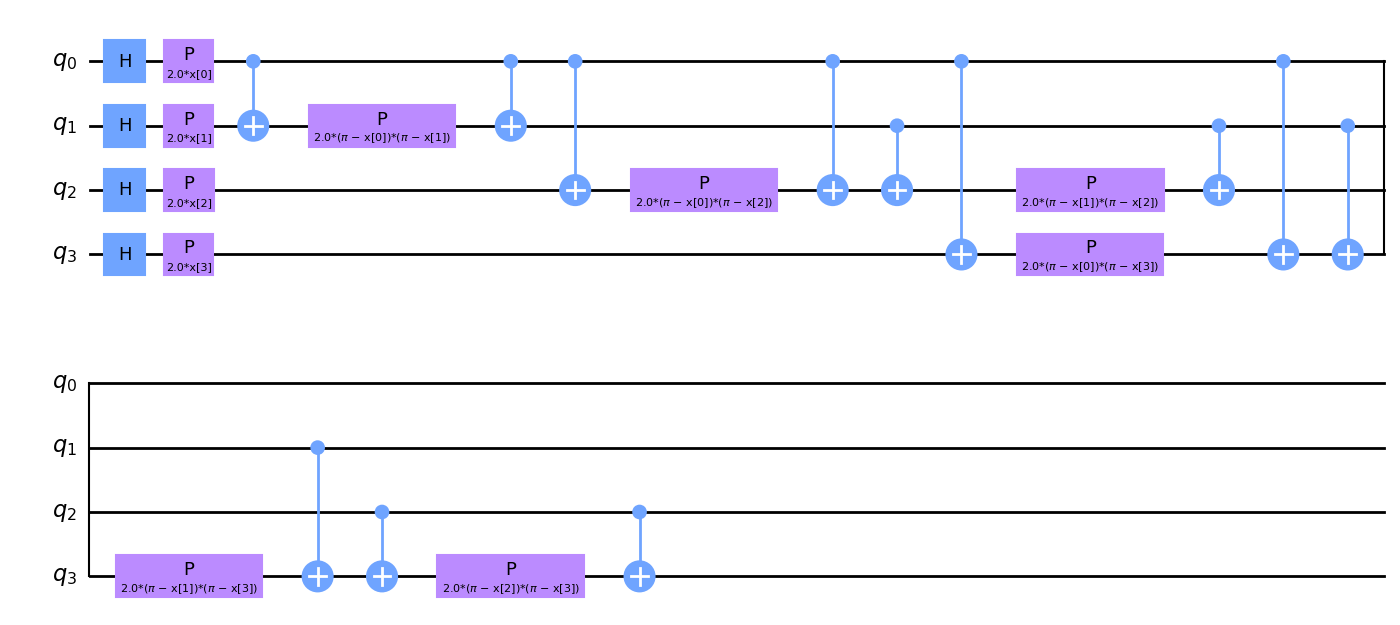

In [7]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

## Ansatz
The ansatz is the parameterized quantum circuit that effectively learns the dataset. We use single qubit rotation gates with tunable parameters to do this. Constructing a good ansatz such that it can reach the optimal solution space is an active research area. For our demo, we use the RealAmplitudes function to construct our ansatz. \
https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes

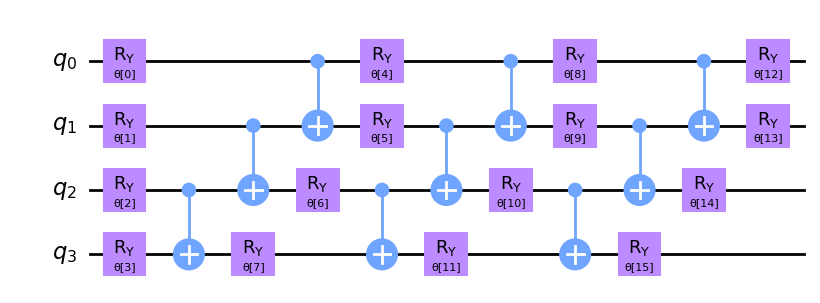

In [8]:
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

After that, we merge the two circuits together. Now our circuit looks much like the general structure above.

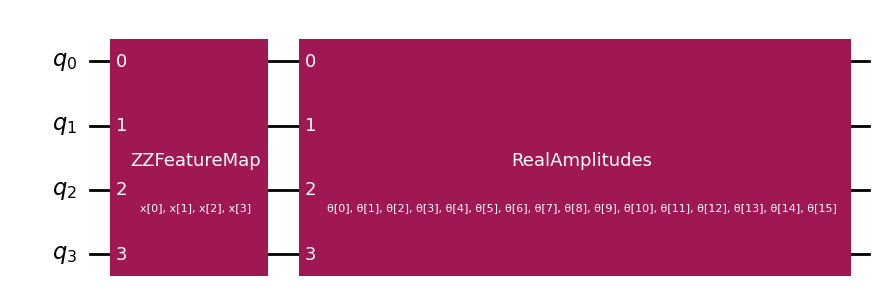

In [9]:
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
circuit.draw('mpl')

## Measurement
We have just constructed a QNN. Classical neural networks have forward and backward propagation. In the case of our current QNN, we only really have a forward propagation through the execution of the circuit. We need a backward method that calculates the gradients needed to update our weights (our parameters). Thankfully, qiskit-machine-learning provides us with a class with the necessary functions and postprocessing methods, SamplerQNN. There is also an EstimatorQNN that uses the Estimator primitive as opposed to the Sampler primitive.

For now, we will focus on SamplerQNN:
https://qiskit-community.github.io/qiskit-machine-learning/_modules/qiskit_machine_learning/neural_networks/sampler_qnn.html

The Sampler primitive is the measurement part that we have left. As the name suggests, it executes the circuit multiple times to gather measurements according to the desired output type. In our case, the measurements are outputted as bitstrings. That is why we have a defined parity function that interprets the output from the Sampler as a class. This is the postprocessing for our forward propagation. For example, using the parity function we defined, '0010' and '1110' would be determined to be the digit 1 while '0110' and '0000' would be classified as digit 0.

We also need a different way to backpropagate for a quantum setting. The method used in these classes is called the Parameter-Shift rule, which we will not cover in detail.

We verify that the SamplerQNN forward propagation works with the inputs we defined.

In [13]:
def parity(x):
    return "{:b}".format(x).count("1") % num_classes
    
sampler = BackendSampler(backend=fake_backend)

sampler_qnn = SamplerQNN(
    circuit=circuit,
    sampler=sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=num_classes,
)

sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)
print(sampler_qnn_forward)

C:\Users\Chris\AppData\Local\Temp\ipykernel_4208\1699821699.py:4: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(backend=fake_backend)


[[0.41894531 0.58105469]]


<a id="sim"></a>
# Training/Testing on a simulator

The final step is to train and test the QNN on the MNIST dataset. We use the NeuralNetworkClassifier class in qiskit-machine-learning to help us do so: https://qiskit-community.github.io/qiskit-machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html

We pass in our SamplerQNN as the network into the classifier, a loss function such as cross entropy, an optimizer with the number of epochs/iterations, and initial parameters to tune.

Note that the COBYLA optimizer we used is a gradient-free optimization algorithm. There are other supported gradient-based optimizers available but we chose COBYLA as a demo. You can find more supported optimizers here such as SPSA: https://github.com/qiskit-community/qiskit-machine-learning/tree/main/qiskit_machine_learning/optimizers

In addition, we provide 5 example initial parameters. As you change the number of qubits, classes, or samples, you may need to find different initial parameters since these 5 are not guaranteed to reach the optimal solution space.

This cell below may take at least 5 minutes to run.

In [14]:
import time

# Callback function that NeuralNetworkClassifier takes in. Used to store losses here
def callback(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)


# Loading pre-saved initial weights to showcase importance of the starting point
initial_weights = np.load("2by2params.npy")
# print(f"Initial weights: {initial_weights}")

losses = []
for i, initial_point in enumerate(initial_weights):
    classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        loss="cross_entropy",
        one_hot=True,
        optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
        initial_point=initial_point, 
        callback=callback
    )
    
    objective_func_vals = []

    print(f"Weight {i}:")
    print(f"Initial weights: {initial_point}")
    
    # fit classifier to data
    start = time.time()
    classifier.fit(train_feats, train_labels)
    elapsed = time.time() - start
    
    losses.append(objective_func_vals)
    
    accuracy = classifier.score(test_feats, test_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Trained weights: {classifier.weights}")
    print(f"Training time: {round(elapsed)} seconds")
    print("---------------------------------------")

Weight 0:
Initial weights: [0.12992151 0.47570493 0.22690935 0.66981399 0.43715192 0.8326782
 0.7002651  0.31236664 0.8322598  0.80476436 0.38747838 0.2883281
 0.6824955  0.13975248 0.1999082  0.00736227]
Accuracy: 0.92
Trained weights: [0.13121863 0.97492617 1.22690935 0.6976791  0.43715192 0.8326782
 0.46990424 1.31236664 0.92938793 0.80476436 0.38747838 1.2883281
 0.6824955  0.13975248 1.1999082  0.00736227]
Training time: 95 seconds
---------------------------------------
Weight 1:
Initial weights: [0.03081783 0.43671739 0.21458467 0.40852864 0.85340307 0.23393949
 0.05830274 0.28138389 0.29359376 0.66191651 0.55703215 0.78389821
 0.66431354 0.40638686 0.81402038 0.16697292]
Accuracy: 0.88
Trained weights: [ 0.01305598 -0.08323151  1.22357655 -0.07416478  1.880339   -0.30888001
  1.07239337  0.26648781  0.22590096  1.73763079  1.65368588  1.83324653
  0.44123758 -0.23034228  0.46656796 -0.15312495]
Training time: 96 seconds
---------------------------------------
Weight 2:
Initial 

The following graphs display the losses for each set of parameters as we trained them.

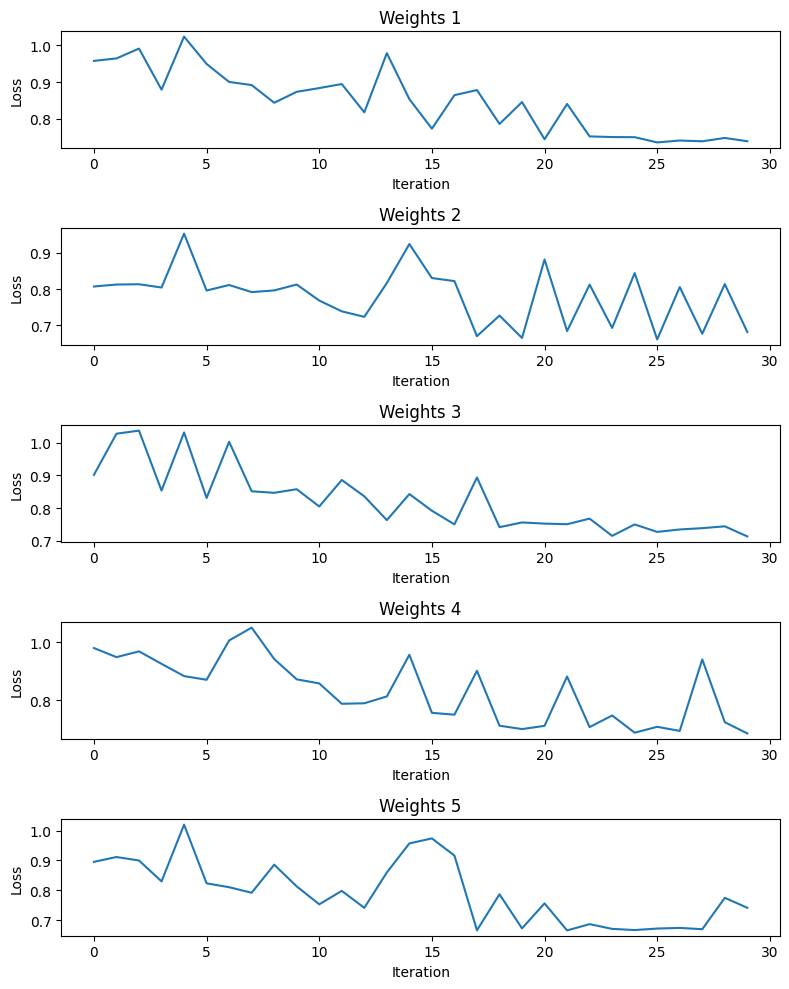

In [18]:
# Create a figure and axes for each array
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 10))  # 5 rows, 1 column

# Loop through the arrays and plot each one
for i, loss in enumerate(losses):
    axes[i].plot(range(len(loss)), loss)
    axes[i].set_title(f'Weights {i + 1}')  # Set the title for each subplot
    axes[i].set_xlabel('Iteration')  # X-axis label
    axes[i].set_ylabel('Loss')   # Y-axis label

# Adjust layout
plt.tight_layout()
plt.show()

Now that we have trained and tested on 5 initial parameters, change the <b>best_accuracy_weights</b> variable below to the parameters with the best accuracy above to see the real-time execution of training losses.

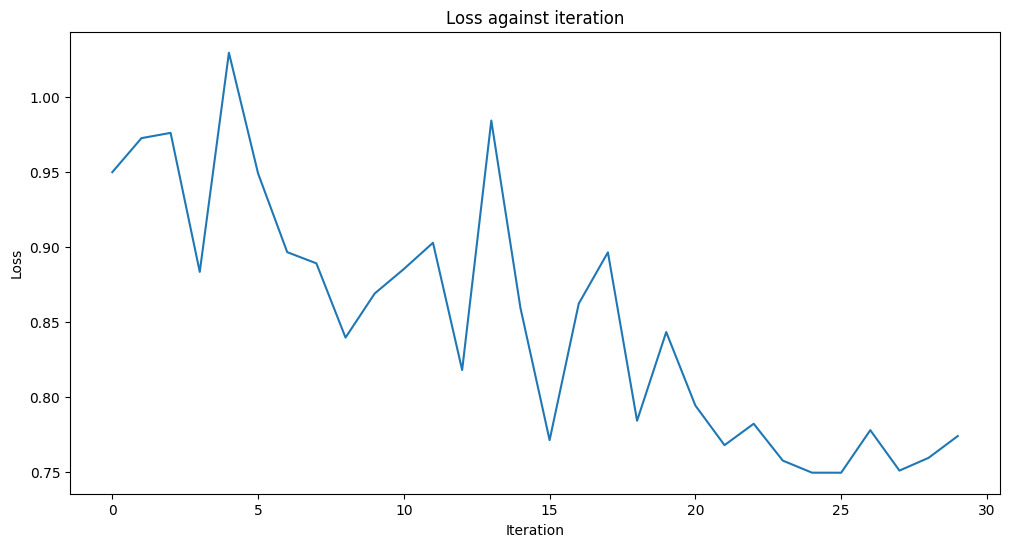

Training time: 94 seconds
Accuracy: 0.84


In [19]:
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Loss against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Modify based on best accuracy
best_accuracy_weights = initial_weights[0]

classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
    initial_point=best_accuracy_weights, 
    callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
classifier.fit(train_feats, train_labels)
elapsed = time.time() - start

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print(f"Training time: {round(elapsed)} seconds")
accuracy = classifier.score(test_feats, test_labels)

print(f"Accuracy: {accuracy}")

Below, we show what our network predicted versus the true digit of the image.

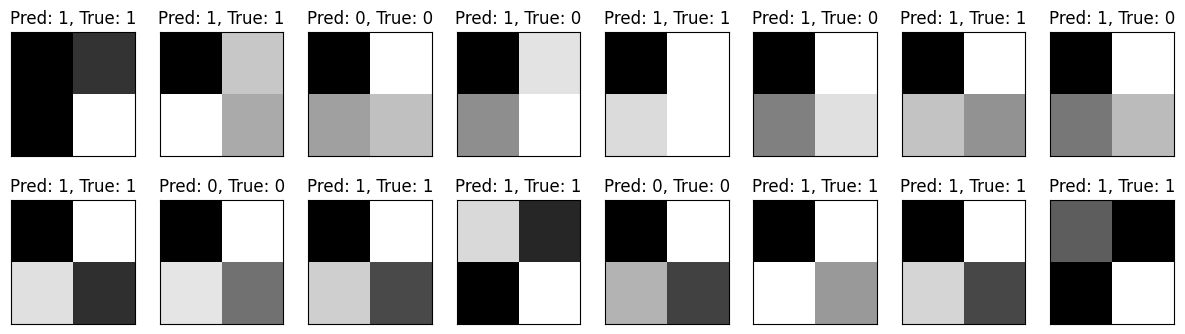

In [20]:
test_pred = classifier.predict(test_feats)

# Plot predicted labels
n_samples_show = 8
n_rows = 2
count = 0
fig, axes = plt.subplots(nrows=n_rows, ncols=n_samples_show, figsize=(15, 4))
for img, true, output in zip(test_imgs, test_labels, test_pred):
    if count == n_samples_show * n_rows:
        break
    
    pred = np.argmax(output)
    gt = np.argmax(true)
    row = count // n_samples_show  # Calculate row index
    col = count % n_samples_show  # Calculate column index

    im_np = img.transpose((1, 2, 0))
    axes[row, col].imshow(im_np, cmap="gray")

    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])
    axes[row, col].set_title("Pred: {}, True: {}".format(pred, gt))

    count += 1

<a id="rpi"></a>
# Training/Testing on ibm_rensselaer
Now, putting all of the steps together, we train and test on a real backend. To do this, we instantiate the Sampler primitive with the true backend associated with our quantum computer and not the simulator based on it. Much of the other steps stay the same. We construct the SamplerQNN, NeuralNetworkClassifier, and finally train and test our QNN.

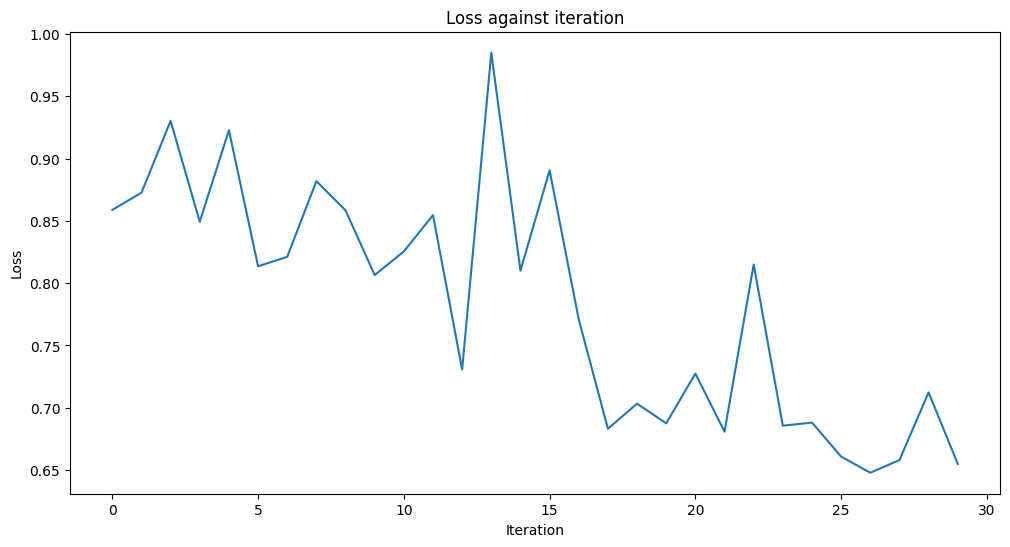

Training time: 8094 seconds
Accuracy: 0.82


In [21]:
real_sampler = BackendSampler(backend=backend)

real_sampler_qnn = SamplerQNN(
    circuit=circuit,
    sampler=real_sampler,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=num_classes,
)

real_classifier = NeuralNetworkClassifier(
    neural_network=real_sampler_qnn,
    loss="cross_entropy",
    one_hot=True,
    optimizer=COBYLA(maxiter=30),  #Default learning rate: 0.01
    initial_point=best_accuracy_weights, 
    callback=callback_graph
)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
start = time.time()
real_classifier.fit(train_feats, train_labels)
elapsed = time.time() - start

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

print(f"Training time: {round(elapsed)} seconds")
accuracy = real_classifier.score(test_feats, test_labels)

print(f"Accuracy: {accuracy}")